## Импорт библиотек

In [30]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications
!pip install livelossplot

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Model
from keras.layers import Dense, Input
from livelossplot import PlotLossesKeras
 
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
 
import gdown
from pathlib import Path
from collections import Counter

## Загрузка данных

In [ ]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:03, 28.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 6.72MB/s]


'train_val_split_utk.csv'

In [ ]:
# поместим название файлов в список filenames
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
 
# количество файлов
print('Количество файлов в датасете UTKFace -', len(filenames))
print('---')
 
# представление имени файла
# имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание
print(filenames[:3])

Количество файлов в датасете UTKFace - 23708
---
['21_1_2_20170116170801014.jpg.chip.jpg', '20_1_0_20170105183449767.jpg.chip.jpg', '11_1_4_20170104005813063.jpg.chip.jpg']


In [ ]:
# формируем датафрейм с именами файлов (будет путем к файлу) и метками классов
 
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []
 
# проверка на корректное имя файла (содержание всех меток)
for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue
 
    # разделение имени файла на составляющие - возраст, пол и раса
    # остальная информация нас не интересует
    # добавляем полученные метки в соответствующие списки
    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
 
# помещаем все полученные данные в pandas dataframe    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg


,img_name,age,race,gender
0,20_1_3_20170105000847091.jpg.chip.jpg,0.172414,3,1
1,37_1_0_20170103183817362.jpg.chip.jpg,0.318966,0,1
2,75_1_0_20170120225456154.jpg.chip.jpg,0.646552,0,1
3,26_1_1_20170113135610650.jpg.chip.jpg,0.224138,1,1
4,57_1_0_20170109220740803.jpg.chip.jpg,0.491379,0,1


In [ ]:
# вспомогательный датасет для разделения данных на тренировочные и валидационные
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head(10)

,is_train
img_name,
29_0_0_20170117180855986.jpg.chip.jpg,1
29_0_4_20170117202712541.jpg.chip.jpg,1
35_0_1_20170117104607288.jpg.chip.jpg,1
17_0_0_20170110231830374.jpg.chip.jpg,1
23_0_0_20170117194023317.jpg.chip.jpg,1
17_1_4_20170103201233799.jpg.chip.jpg,0
9_0_0_20170110220058915.jpg.chip.jpg,0
45_0_3_20170119203950879.jpg.chip.jpg,1
52_1_2_20170112205146963.jpg.chip.jpg,1


In [ ]:
# разделение датасета на тренировочный и валидационный
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
 
# размеры тренировчного и валидационного датасетов
print('Размер тренировочного датасета -', df_train.shape[0])
print('Размер валидационного датасета -', df_val.shape[0])

Размер тренировочного датасета - 18946
Размер валидационного датасета - 4759


In [ ]:
# функции для отображения лица с метками классов
 
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

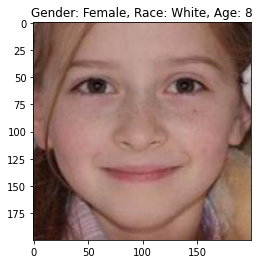

In [ ]:
# убедимя, функции работаются правильно
 
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

In [ ]:
# функция предобработки изображения для подалчи на вход сети
 
def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(image_, version=2) из keras_vggface
    """
    
    preprocessed = utils.preprocess_input(image_, version=2)
    
    return preprocessed
 
# функция обратного преобразования изображения
 
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib
 
    return: корректно отображаеая картинка типа np.uint8. 
    """
    image = np.copy(vggface_image)
 
    image[..., 2] += 131.0912
    image[..., 1] += 103.8827
    image[..., 0] += 91.4953
 
    image = image[..., ::-1].astype(np.uint8)
    
    return image

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 224
 
# генератор изображений для сети с лицами, прошедшими предобработку
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)
 
 
# тренировочный и валидационный генератор изображений, которые пройдут преобработку
# и поступят на вход нейронной сети, классифицирующей изображение по полу (gender)
 
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        directory=str(data_folder),
        class_mode="raw",
        x_col="img_name", 
        y_col=["gender", "race", "age"], # нас интересуют все три столбца
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE)

val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        directory=str(data_folder),
        class_mode="raw",
        x_col="img_name", 
        y_col=["gender", "race", "age"], 
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=False)
 
def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])
 
    Для такого превращения и нужна эта функция.
 
    """
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1].astype('float32'), 3, axis=1)
        labels = [labels[0].reshape((len(labels[0]),)),
                  labels[1].reshape((len(labels[1]),)),
                  labels[2].reshape((len(labels[2]),))]
        yield image, labels

        

Found 18946 validated image filenames.
Found 4759 validated image filenames.


## Обучение модели на предсказание пола, расы и возраста

In [ ]:
# прикрепим гугл диск к виртуальной машине 
from google.colab import drive
 
drive.mount('/content/drive/')

Mounted at /content/drive/


### Создание объекта нейронной сети VGGFace со структурой ResNet50

In [31]:
vgg_model = VGGFace(input_shape=(224, 224, 3), model='resnet50')

### Transfer Learning

Сперва мы попробуем обучить только "голову" нейронной сети - выходной классификатор. В исходной сети классификатор определеят вероятности принадлежности к одному из 8631 классу. Нам же нужен бинарный классификатор - male/female. Т.к. как наша сеть должна будет предсказывать сразу 3 класс - возраст, расу, пол - на выходе из сети мы будем иметь 3 "головы", каждая из которых отвечает за свое предсказание

In [32]:
vgg_model.trainable = False

# берем на последний слой модели VGGFace слой flatten
output_layer = vgg_model.get_layer('flatten').output

# классифитор пола
output_gender = Dense(1, activation='sigmoid', name='gender')(output_layer)

# классифитор расы
output_race = Dense(5, activation='softmax', name='race')(output_layer)

# определеитель возраста
output_age = Dense(1, activation='sigmoid', name='age')(output_layer)

# определение новой модели с 3-мя выходами
model = Model(vgg_model.input, outputs=[output_gender, output_race, output_age])

Мы имеем 14,343 обучаемых параметра модели и 23,561,152 параматра, уже обученных.

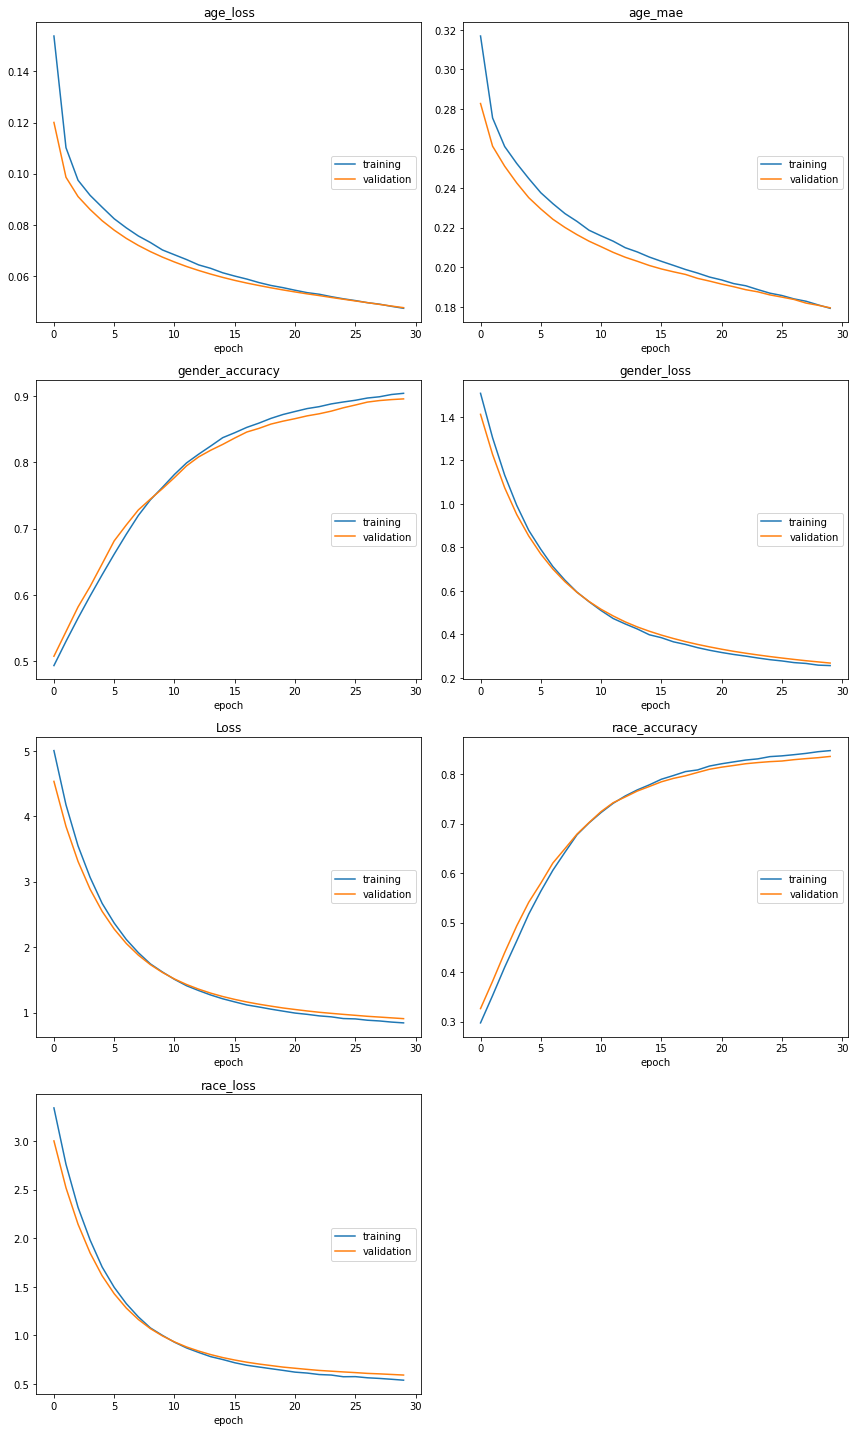

age_loss
	training         	 (min:    0.047, max:    0.154, cur:    0.047)
	validation       	 (min:    0.048, max:    0.120, cur:    0.048)
age_mae
	training         	 (min:    0.179, max:    0.317, cur:    0.179)
	validation       	 (min:    0.179, max:    0.283, cur:    0.179)
gender_accuracy
	training         	 (min:    0.493, max:    0.904, cur:    0.904)
	validation       	 (min:    0.507, max:    0.896, cur:    0.896)
gender_loss
	training         	 (min:    0.257, max:    1.509, cur:    0.257)
	validation       	 (min:    0.268, max:    1.412, cur:    0.268)
Loss
	training         	 (min:    0.844, max:    5.002, cur:    0.844)
	validation       	 (min:    0.909, max:    4.532, cur:    0.909)
race_accuracy
	training         	 (min:    0.297, max:    0.848, cur:    0.848)
	validation       	 (min:    0.326, max:    0.836, cur:    0.836)
race_loss
	training         	 (min:    0.540, max:    3.339, cur:    0.540)
	validation       	 (min:    0.593, max:    3.000, cur:    0.593)


In [24]:
# путь для сохранения файла с лучшими весами на Google Disk
path = Path("/content/drive/My Drive/vggface_model/gender_tranfer_learn")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = "best_weigths.h5"  
cpt_path =str(path / cpt_filename)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1e-4),
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mae', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

EPOCHS = 30
history = model.fit(
    split_outputs(train_generator),
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_data=split_outputs(val_generator),
    validation_steps=len(val_generator),
    callbacks=[checkpoint, PlotLossesKeras()])

После 30 шагов обучения были получены следующие результаты:
- точность определения пола - 89,6 %;
- точность определения расы - 83.6 %;
- среднее абсолютное отклонение возраста - 0.179

Результат хороший, но не отличный. Признаков переобучения не наблюдается, поэтому данную модель можно попробовать обучить еще

### Fine Tuning

Теперь я буду оставлять обучаемыми n-ое количество слоев для обучения на своих данных. Оптимальное количество слоев будет выбрано исходя из метрик сети - сеть должна давать хороший показатель качества и не уметь признаков переобучения

In [33]:
vgg_model.trainable = True

for layer in vgg_model.layers[:169]:
  layer.trainable = False

# берем на последний слой модели VGGFace слой flatten
output_layer = vgg_model.get_layer('flatten').output

# классифитор пола
output_gender = Dense(1, activation='sigmoid', name='gender')(output_layer)

# классифитор расы
output_race = Dense(5, activation='softmax', name='race')(output_layer)

# определеитель возраста
output_age = Dense(1, activation='sigmoid', name='age')(output_layer)

# определение новой модели с 3-мя выходами
model = Model(vgg_model.input, outputs=[output_gender, output_race, output_age])

Мы имеем 1,067,015 обучаемых параметра модели и 22,508,480 параматра, уже обученных.

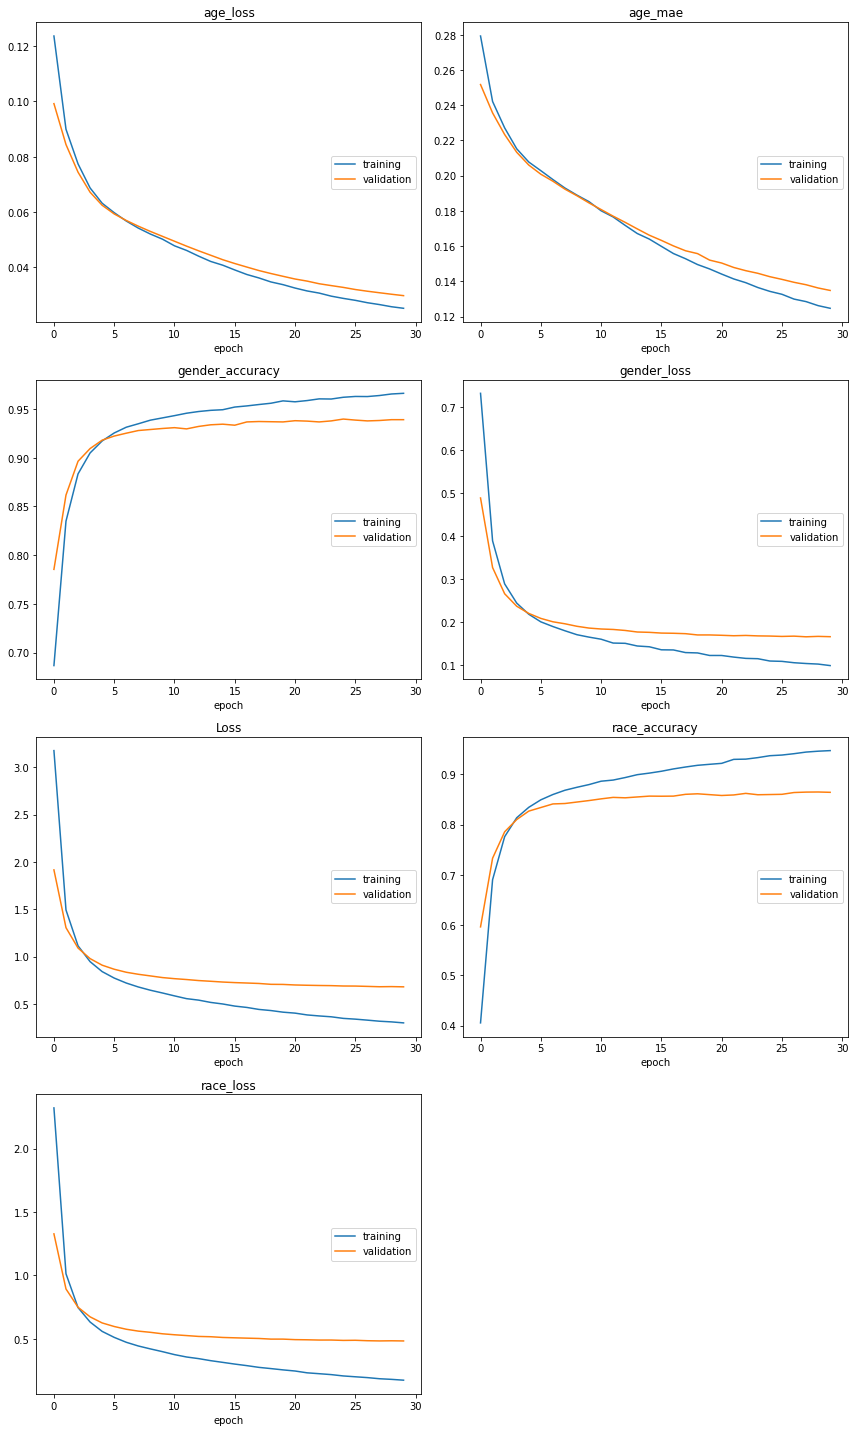

age_loss
	training         	 (min:    0.025, max:    0.124, cur:    0.025)
	validation       	 (min:    0.030, max:    0.099, cur:    0.030)
age_mae
	training         	 (min:    0.125, max:    0.279, cur:    0.125)
	validation       	 (min:    0.135, max:    0.252, cur:    0.135)
gender_accuracy
	training         	 (min:    0.687, max:    0.966, cur:    0.966)
	validation       	 (min:    0.785, max:    0.940, cur:    0.939)
gender_loss
	training         	 (min:    0.099, max:    0.732, cur:    0.099)
	validation       	 (min:    0.166, max:    0.488, cur:    0.166)
Loss
	training         	 (min:    0.299, max:    3.175, cur:    0.299)
	validation       	 (min:    0.680, max:    1.915, cur:    0.680)
race_accuracy
	training         	 (min:    0.405, max:    0.947, cur:    0.947)
	validation       	 (min:    0.596, max:    0.865, cur:    0.864)
race_loss
	training         	 (min:    0.175, max:    2.320, cur:    0.175)
	validation       	 (min:    0.484, max:    1.328, cur:    0.484)


In [26]:
# путь для сохранения файла с лучшими весами на Google Disk
path = Path("/content/drive/My Drive/vggface_model/gender_fine_tuning_169")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = "best_weigths.h5"  
cpt_path =str(path / cpt_filename)
 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1e-4),
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})
 
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mae', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
 
EPOCHS = 30
history = model.fit(
    split_outputs(train_generator),
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_data=split_outputs(val_generator),
    validation_steps=len(val_generator),
    callbacks=[checkpoint, PlotLossesKeras()])

После 30 шагов обучения были получены следующие результаты:
- точность определения пола - 94,0 %;
- точность определения расы - 86.5 %;
- среднее абсолютное отклонение возраста - 0.135

Результат лучше, чем при transfer learning, но начинает наблюдаться сильное переобучения на тренировочных данных для классификатора расы. При увеличении обучаемых слоев или количества эпох обучения, переобучение будет только расти

### Transfer Learning с дополнительными слоями

Из опыта с fine-tuning сети видно, что модель имеет отчетливые признаки переобучения - график сильно расходятся, точность на тренировочных данных намного выше, чем на вылидационных

К тому же видно, что регрессор возраста сходится медленно и далек от оптимального результата.

Выходом из данной ситуации может быть добавления в конец модели собственных скрытых слоев, а потом уже классификатор.

Также попробуем изменить функцию активации - ReLU на ELU

#### Вариант 1 
1 общий дополнительный слой на 256 нейронов и один дополнительный слой для регрессора возраста на 1024 нейронов

In [34]:
vgg_model.trainable = False
 
# берем на последний слой модели VGGFace слой flatten
output_layer = vgg_model.get_layer('flatten').output
 
# добавление дополнительного скрытого слоя
x = Dense(256, activation='elu', name='extra_1')(output_layer)
 
# классифитор пола
output_gender = Dense(1, activation='sigmoid', name='gender')(x)
 
# классифитор расы
output_race = Dense(5, activation='softmax', name='race')(x)
 
# определеитель возраста
x_age = Dense(1024, activation='elu', name='extra_age')(x)
output_age = Dense(1, activation='sigmoid', name='age')(x_age)
 
# определение новой модели с 3-мя выходами
model = Model(vgg_model.input, outputs=[output_gender, output_race, output_age])

Мы имеем 790,279 обучаемых параметра модели и 23,561,152 параматра, уже обученных.

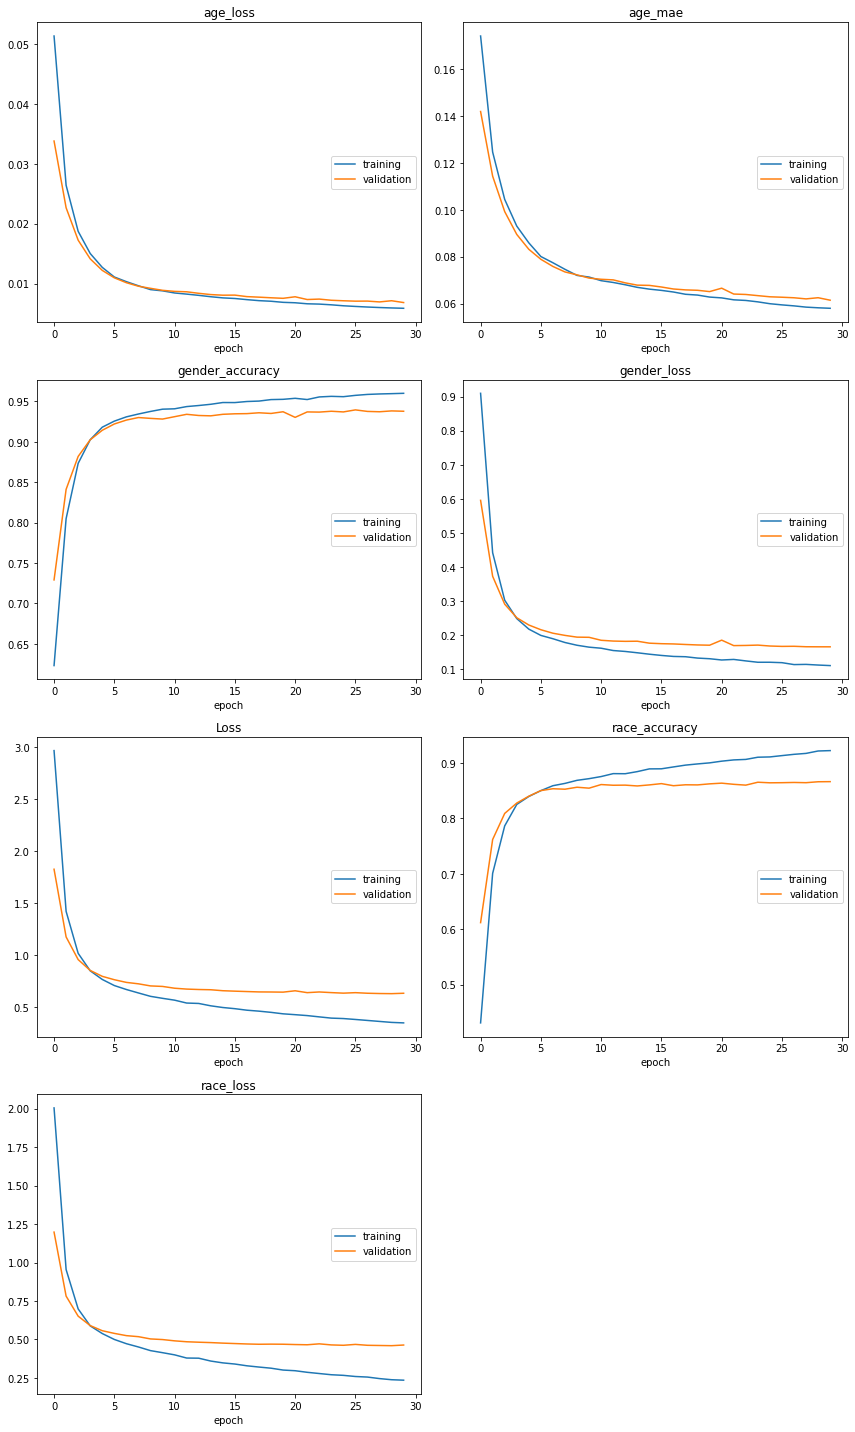

age_loss
	training         	 (min:    0.006, max:    0.051, cur:    0.006)
	validation       	 (min:    0.007, max:    0.034, cur:    0.007)
age_mae
	training         	 (min:    0.058, max:    0.174, cur:    0.058)
	validation       	 (min:    0.061, max:    0.142, cur:    0.061)
gender_accuracy
	training         	 (min:    0.623, max:    0.960, cur:    0.960)
	validation       	 (min:    0.729, max:    0.939, cur:    0.938)
gender_loss
	training         	 (min:    0.110, max:    0.909, cur:    0.110)
	validation       	 (min:    0.166, max:    0.595, cur:    0.166)
Loss
	training         	 (min:    0.352, max:    2.965, cur:    0.352)
	validation       	 (min:    0.632, max:    1.827, cur:    0.636)
race_accuracy
	training         	 (min:    0.431, max:    0.922, cur:    0.922)
	validation       	 (min:    0.612, max:    0.866, cur:    0.866)
race_loss
	training         	 (min:    0.235, max:    2.005, cur:    0.235)
	validation       	 (min:    0.459, max:    1.197, cur:    0.464)


In [29]:
# путь для сохранения файла с лучшими весами на Google Disk
path = Path("/content/drive/My Drive/vggface_model/tranfer_learn_with_extra_1")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = "best_weigths.h5"  
cpt_path =str(path / cpt_filename)
 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1e-4),
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})
 
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mae', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
 
EPOCHS = 30
history = model.fit(
    split_outputs(train_generator),
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_data=split_outputs(val_generator),
    validation_steps=len(val_generator),
    callbacks=[checkpoint, PlotLossesKeras()])

После 30 шагов обучения были получены следующие результаты:
- точность определения пола - 93,9 %;
- точность определения расы - 86.6 %;
- среднее абсолютное отклонение возраста - 0.061

Результат по классификаторам пола и расы остался таким же, как и при fine-tuning с последними 6-ю размороженными слоями. Но переобучение на тренировочных данных классификатора расы уменьшилось (но все равно присутствует такое явление). Регрессор определения возраста стал работать в 2 раза лучше, по сравнению с предыдущим вариантом